<a href="https://colab.research.google.com/github/akshara12code/Audio-text-translation/blob/main/ConVnext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


In [ ]:
# # Configure matplotlib for different environments
# try:
#     # Try to use interactive backend
#     matplotlib.use('TkAgg')  # or 'Qt5Agg'
# except ImportError:
#     try:
#         matplotlib.use('Agg')  # Non-interactive backend
#         print("Using non-interactive backend. Plots will be saved instead of displayed.")
#     except ImportError:
#         pass

In [ ]:
# Enable interactive mode
plt.ion()

In [ ]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [ ]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
print("Downloading and preparing training set...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

print("Downloading and preparing test set...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Loading CIFAR-10 dataset...


In [ ]:
# Dataset information
print(f"\nDataset Information:")
print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"Image shape: {trainset[0][0].shape}")


Dataset Information:
Training samples: 50000
Test samples: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image shape: torch.Size([3, 32, 32])



Displaying sample images from dataset...
Sample images also saved as 'cifar10_sample_images.png'


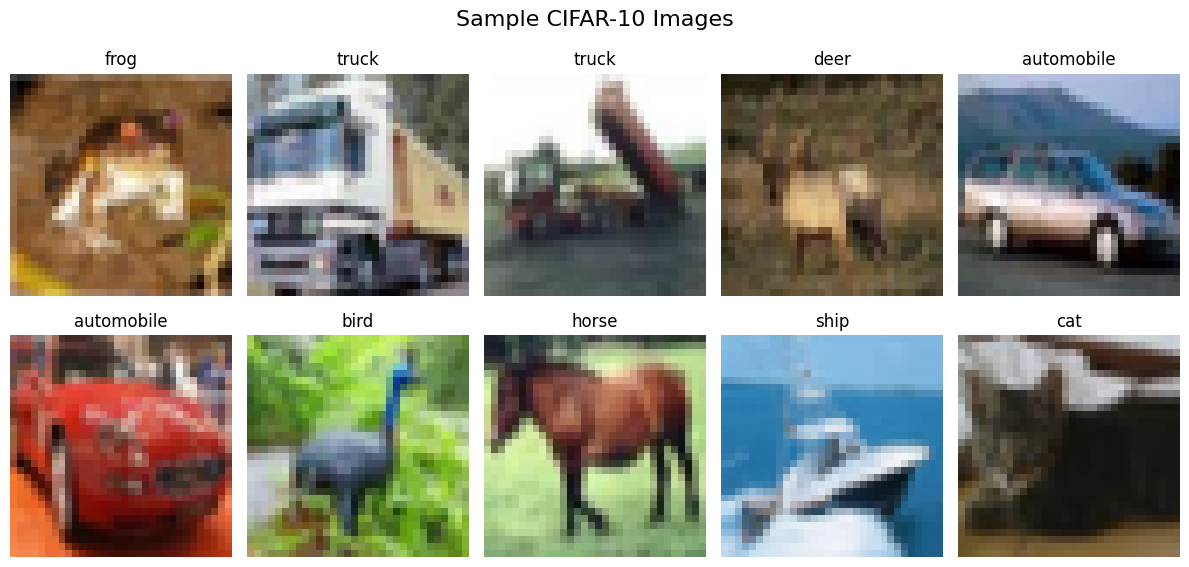

In [ ]:
# Verify dataset loading by showing sample images
def show_sample_images():
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('Sample CIFAR-10 Images', fontsize=16)

    # Get some samples without transforms for visualization
    raw_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=False, transform=transforms.ToTensor())

    for i in range(10):
        img, label = raw_dataset[i]
        row = i // 5
        col = i % 5

        # Convert tensor to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()

        axes[row, col].imshow(img_np)
        axes[row, col].set_title(f'{classes[label]}')
        axes[row, col].axis('off')

    plt.tight_layout()

    # Try multiple methods to display/save the plot
    try:
        plt.show()
        plt.pause(0.1)  # Brief pause to ensure display
    except:
        print("Display failed, saving plot instead...")
        plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
        print("Sample images saved as 'sample_images.png'")

    # Also save the plot regardless
    plt.savefig('cifar10_sample_images.png', dpi=150, bbox_inches='tight')
    print("Sample images also saved as 'cifar10_sample_images.png'")

    return fig

# Show sample images
print("\nDisplaying sample images from dataset...")
show_sample_images()

In [ ]:
# Class distribution in training set
def analyze_class_distribution():
    """Analyze and visualize class distribution"""
    train_labels = [trainset[i][1] for i in range(len(trainset))]
    test_labels = [testset[i][1] for i in range(len(testset))]

    train_unique, train_counts = np.unique(train_labels, return_counts=True)
    test_unique, test_counts = np.unique(test_labels, return_counts=True)

    print(f"\nClass distribution in training set:")
    for i, (class_idx, count) in enumerate(zip(train_unique, train_counts)):
        print(f"{classes[class_idx]}: {count} samples")

    print(f"\nClass distribution in test set:")
    for i, (class_idx, count) in enumerate(zip(test_unique, test_counts)):
        print(f"{classes[class_idx]}: {count} samples")

    # Plot distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.bar([classes[i] for i in train_unique], train_counts, color='skyblue', alpha=0.7)
    ax1.set_title('Training Set Class Distribution')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)

    ax2.bar([classes[i] for i in test_unique], test_counts, color='lightcoral', alpha=0.7)
    ax2.set_title('Test Set Class Distribution')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Number of Samples')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()

    # Try to show plot and save it
    try:
        plt.show()
        plt.pause(0.1)
    except:
        print("Display failed, saving plot instead...")

    plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
    print("Class distribution saved as 'class_distribution.png'")

    return train_counts, test_counts

print("Analyzing class distribution...")
train_class_counts, test_class_counts = analyze_class_distribution()

Analyzing class distribution...

Class distribution in training set:
airplane: 5000 samples
automobile: 5000 samples
bird: 5000 samples
cat: 5000 samples
deer: 5000 samples
dog: 5000 samples
frog: 5000 samples
horse: 5000 samples
ship: 5000 samples
truck: 5000 samples

Class distribution in test set:
airplane: 1000 samples
automobile: 1000 samples
bird: 1000 samples
cat: 1000 samples
deer: 1000 samples
dog: 1000 samples
frog: 1000 samples
horse: 1000 samples
ship: 1000 samples
truck: 1000 samples
Class distribution saved as 'class_distribution.png'


In [ ]:
# Test data loading
print("\nTesting data loading...")
sample_batch = next(iter(trainloader))
print(f"Batch shape: {sample_batch[0].shape}")
print(f"Labels shape: {sample_batch[1].shape}")
print(f"Sample batch labels: {sample_batch[1][:10].tolist()}")

print("\nDataset loading completed successfully!")
print("=" * 60)


Testing data loading...
Batch shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])
Sample batch labels: [9, 9, 2, 8, 7, 1, 8, 1, 8, 1]

Dataset loading completed successfully!


In [ ]:
# Simple ConvNeXt-like architecture
class ConvNeXtBlock(nn.Module):
    def __init__(self, dim, drop_path=0.):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = nn.Identity()  # Simplified for this example

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
        x = input + self.drop_path(x)
        return x

In [ ]:

class LayerNorm2d(nn.Module):
    """LayerNorm for 2D feature maps (channels-first format)"""
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        # x shape: (N, C, H, W)
        mean = x.mean(dim=1, keepdim=True)  # (N, 1, H, W)
        var = x.var(dim=1, keepdim=True)    # (N, 1, H, W)
        x = (x - mean) / torch.sqrt(var + self.eps)
        x = x * self.weight.view(1, -1, 1, 1) + self.bias.view(1, -1, 1, 1)
        return x

In [ ]:
class SimpleConvNeXt(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Stem - downsample input from 32x32 to 8x8
        self.stem = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=4, stride=4),
            LayerNorm2d(96)
        )

        # Stage 1: 96 channels, 8x8 feature maps
        self.stage1 = nn.Sequential(
            ConvNeXtBlock(96),
            ConvNeXtBlock(96),
        )

        # Downsample: 8x8 -> 4x4
        self.downsample = nn.Sequential(
            LayerNorm2d(96),
            nn.Conv2d(96, 192, kernel_size=2, stride=2),
        )

        # Stage 2: 192 channels, 4x4 feature maps
        self.stage2 = nn.Sequential(
            ConvNeXtBlock(192),
            ConvNeXtBlock(192),
        )

        # Head
        self.norm = LayerNorm2d(192)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Linear(192, num_classes)

    def forward(self, x):
        # Input: (N, 3, 32, 32)
        x = self.stem(x)        # (N, 96, 8, 8)
        x = self.stage1(x)      # (N, 96, 8, 8)
        x = self.downsample(x)  # (N, 192, 4, 4)
        x = self.stage2(x)      # (N, 192, 4, 4)
        x = self.norm(x)        # (N, 192, 4, 4)
        x = self.avgpool(x)     # (N, 192, 1, 1)
        x = torch.flatten(x, 1) # (N, 192)
        x = self.head(x)        # (N, 10)
        return x

In [ ]:
# Initialize model
model = SimpleConvNeXt(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [ ]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

    return running_loss / len(loader), 100. * correct / total

In [ ]:
# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

            # Get probabilities and predictions
            probs = torch.softmax(output, dim=1)
            _, predicted = output.max(1)

            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = 100. * correct / total
    avg_loss = test_loss / len(loader)

    return avg_loss, accuracy, np.array(all_preds), np.array(all_targets), np.array(all_probs)

In [ ]:
# Training loop
print("Starting training...")
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

num_epochs = 10  # Reduced for faster training

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Train
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate
    test_loss, test_acc, _, _, _ = evaluate(model, testloader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    scheduler.step()

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Starting training...

Epoch 1/10
--------------------------------------------------
Batch 0/391, Loss: 1.3041, Acc: 52.34%
Batch 100/391, Loss: 1.3797, Acc: 55.28%
Batch 200/391, Loss: 1.2339, Acc: 55.49%
Batch 300/391, Loss: 1.3467, Acc: 55.77%
Train Loss: 1.2155, Train Acc: 56.33%
Test Loss: 1.1401, Test Acc: 59.13%

Epoch 2/10
--------------------------------------------------
Batch 0/391, Loss: 1.1915, Acc: 57.81%
Batch 100/391, Loss: 1.2008, Acc: 59.58%
Batch 200/391, Loss: 1.1772, Acc: 59.53%
Batch 300/391, Loss: 1.0788, Acc: 59.85%
Train Loss: 1.1186, Train Acc: 60.13%
Test Loss: 1.0630, Test Acc: 62.00%

Epoch 3/10
--------------------------------------------------
Batch 0/391, Loss: 1.0448, Acc: 61.72%
Batch 100/391, Loss: 1.2390, Acc: 61.66%
Batch 200/391, Loss: 0.9994, Acc: 62.25%
Batch 300/391, Loss: 1.0762, Acc: 62.89%
Train Loss: 1.0415, Train Acc: 63.02%
Test Loss: 1.0010, Test Acc: 63.91%

Epoch 4/10
--------------------------------------------------
Batch 0/391, Loss: 

In [ ]:
# Final evaluation for detailed metrics
print("\nFinal evaluation...")
test_loss, test_acc, y_pred, y_true, y_probs = evaluate(model, testloader, criterion, device)


Final evaluation...


In [ ]:
# 2. Confusion Matrix
plt.subplot(3, 4, 3)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(1029.4178743961354, 0.5, 'Actual')

In [ ]:
# 3. Normalized Confusion Matrix
plt.subplot(3, 4, 4)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')



Text(1433.765700483092, 0.5, 'Actual')

In [ ]:
# 4. Per-class accuracy
plt.subplot(3, 4, 5)
class_acc = cm_norm.diagonal()
plt.bar(classes, class_acc)
plt.title('Per-class Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

In [ ]:
# 5. ROC Curves (One-vs-Rest)
plt.subplot(3, 4, 6)
# Binarize the output
y_true_bin = label_binarize(y_true, classes=list(range(10)))
n_classes = 10


In [ ]:
# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Plot ROC curves for first few classes (to avoid clutter)
colors = plt.cm.Set1(np.linspace(0, 1, 5))
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (First 5 Classes)')
plt.legend(loc="lower right")

In [ ]:
# 6. Average ROC AUC scores
plt.subplot(3, 4, 7)
auc_scores = [roc_auc[i] for i in range(n_classes)]
plt.bar(classes, auc_scores)
plt.title('AUC Scores per Class')
plt.xlabel('Classes')
plt.ylabel('AUC')
plt.xticks(rotation=45)
plt.ylim([0, 1])

(0.0, 1.0)

In [ ]:
# 7. Prediction confidence distribution
plt.subplot(3, 4, 8)
max_probs = np.max(y_probs, axis=1)
plt.hist(max_probs, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Maximum Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')



Text(0.5, 1.0, 'Prediction Confidence Distribution')

In [ ]:

# 8. Class distribution in dataset
plt.subplot(3, 4, 9)
unique, counts = np.unique(y_true, return_counts=True)
plt.bar([classes[i] for i in unique], counts)
plt.title('Class Distribution in Test Set')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

In [ ]:
# 11. Model parameters count
plt.subplot(3, 4, 12)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

plt.bar(['Total', 'Trainable'], [total_params, trainable_params])
plt.title('Model Parameters')
plt.ylabel('Number of Parameters')
for i, v in enumerate([total_params, trainable_params]):
    plt.text(i, v + total_params*0.01, f'{v:,}', ha='center')

plt.tight_layout()

In [ ]:
# Try to display the plot
try:
    plt.show()
    plt.pause(2)  # Keep plot open for 2 seconds
except:
    print("Interactive display not available, plot saved to file.")

In [ ]:
# Alternative: Create individual plots if main plot doesn't display
print("\nCreating individual plots for better visibility...")


Creating individual plots for better visibility...


In [ ]:
# Individual confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=200, bbox_inches='tight')
print("Confusion matrix saved as 'confusion_matrix.png'")

try:
    plt.show()
except:
    pass

Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
# Print summary statistics
print(f"\nSummary:")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Average AUC Score: {np.mean(auc_scores):.3f}")



Summary:
Final Test Accuracy: 8.87%
Total Parameters: 851,434
Trainable Parameters: 851,434
Average AUC Score: 0.461
